# EDA

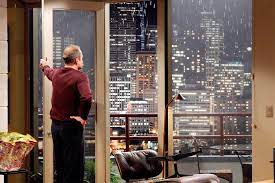

In [5]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [24]:
df = pd.read_csv('data/eda.csv') 

#split renovated vs not renovated
df["renovated"] = df["yr_renovated"] > 0
renovated_count = df["renovated"].value_counts()
print ("renovated counts:\n", renovated_count)

#calculate average price per sqft for renovated vs not renovated
df["price_per_sqft"] = df["price"] / df["sqft_living"]
avg_renovated = df.loc[df["renovated"], "price_per_sqft"].mean()
avg_not_renovated = df.loc[~df["renovated"], "price_per_sqft"].mean()

print("Avg price/sqft (renovated):", avg_renovated)
print("Avg price/sqft (not renovated):", avg_not_renovated)

#calculate renovation premium
premium_pct = ((avg_renovated - avg_not_renovated) / avg_not_renovated) * 100
print("Renovation premium (%):", premium_pct.round(2))

# Average price per sqft by grade and renovation status
grade_stats = (
    df.groupby(["grade", "renovated"])["price_per_sqft"]
      .agg(["mean", "count"])
      .reset_index()
)
print(grade_stats.head())

grade_pivot = grade_stats.pivot(
    index="grade",
    columns="renovated",
    values="mean"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

# Calculate premium (%)
grade_pivot["premium_pct"] = (
    (grade_pivot["avg_renovated"] - grade_pivot["avg_not_renovated"])
    / grade_pivot["avg_not_renovated"]
) * 100

print(grade_pivot)


# Average price per sqft by zipcode and renovation status
zip_stats = (
    df.groupby(["zipcode", "renovated"])["price_per_sqft"]
      .agg(["mean", "count"])
      .reset_index()
)

zip_pivot = zip_stats.pivot(
    index="zipcode",
    columns="renovated",
    values="mean"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

zip_pivot["premium_pct"] = (
    (zip_pivot["avg_renovated"] - zip_pivot["avg_not_renovated"])
    / zip_pivot["avg_not_renovated"]
) * 100

# Drop zipcodes where one of the groups is missing
zip_pivot = zip_pivot.dropna(subset=["avg_not_renovated", "avg_renovated"])

# Optional: also filter by minimum counts to avoid noisy zipcodes
zip_counts = (
    df.groupby(["zipcode", "renovated"])["price_per_sqft"]
      .size()
      .unstack(fill_value=0)
      .rename(columns={False: "count_not_renovated", True: "count_renovated"})
)

zip_pivot = zip_pivot.join(zip_counts)

# For example: keep only zipcodes with at least 20 non-ren and 10 ren
zip_pivot_filtered = zip_pivot[
    (zip_pivot["count_not_renovated"] >= 20) &
    (zip_pivot["count_renovated"] >= 10)
]

print(zip_pivot_filtered.sort_values("premium_pct", ascending=False).head(10))

# calculate premium by year renovated
df["date"] = pd.to_datetime(df["date"])
df["sale_year"] = df["date"].dt.year

year_stats = (
    df.groupby(["sale_year", "renovated"])["price_per_sqft"]
      .agg(["mean", "count"])
      .reset_index()
)

year_pivot = year_stats.pivot(
    index="sale_year",
    columns="renovated",
    values="mean"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

year_pivot["premium_pct"] = (
    (year_pivot["avg_renovated"] - year_pivot["avg_not_renovated"])
    / year_pivot["avg_not_renovated"]
) * 100

year_pivot = year_pivot.dropna(subset=["avg_not_renovated", "avg_renovated"])

print(year_pivot)


renovated counts:
 renovated
False    20853
True       744
Name: count, dtype: int64
Avg price/sqft (renovated): 321.33813473598997
Avg price/sqft (not renovated): 262.1027552217057
Renovation premium (%): 22.6
   grade  renovated    mean  count
0      3      False 503.846      1
1      4      False 330.758     26
2      4       True 634.615      1
3      5      False 279.608    238
4      5       True 238.786      4
renovated  avg_not_renovated  avg_renovated  premium_pct
grade                                                   
3                    503.846            NaN          NaN
4                    330.758        634.615       91.867
5                    279.608        238.786      -14.600
6                    272.321        235.165      -13.644
7                    250.878        283.578       13.034
8                    255.400        330.923       29.570
9                    271.530        373.057       37.391
10                   301.920        463.074       53.377
11       

In [25]:
# 1) Make sure these exist
df["renovated"] = df["yr_renovated"] > 0
df["price_per_sqft"] = df["price"] / df["sqft_living"]

# 2) Group by zipcode + renovated
zip_stats = (
    df.groupby(["zipcode", "renovated"])["price_per_sqft"]
      .agg(["mean", "count"])
      .reset_index()
)

print("zip_stats head:")
print(zip_stats.head())

# 3) Pivot: renovated = columns, zipcode = rows
zip_pivot = zip_stats.pivot(
    index="zipcode",
    columns="renovated",
    values="mean"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

print("\nzip_pivot head (before premium):")
print(zip_pivot.head())

# 4) Premium %
zip_pivot["premium_pct"] = (
    (zip_pivot["avg_renovated"] - zip_pivot["avg_not_renovated"])
    / zip_pivot["avg_not_renovated"]
) * 100

print("\nzip_pivot head (with premium):")
print(zip_pivot.head())

print("\nTop 10 zipcodes by renovation premium:")
print(zip_pivot.sort_values("premium_pct", ascending=False).head(10))

zip_stats head:
   zipcode  renovated    mean  count
0    98001      False 151.081    357
1    98001       True 175.186      4
2    98002      False 151.545    194
3    98002       True 136.775      5
4    98003      False 157.129    278

zip_pivot head (before premium):
renovated  avg_not_renovated  avg_renovated
zipcode                                    
98001                151.081        175.186
98002                151.545        136.775
98003                157.129        154.985
98004                474.497        487.091
98005                313.876        359.701

zip_pivot head (with premium):
renovated  avg_not_renovated  avg_renovated  premium_pct
zipcode                                                 
98001                151.081        175.186       15.955
98002                151.545        136.775       -9.747
98003                157.129        154.985       -1.364
98004                474.497        487.091        2.654
98005                313.876        359.701   

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# already done earlier:
# df["renovated"] = df["yr_renovated"] > 0
# df["price_per_sqft"] = df["price"] / df["sqft_living"]





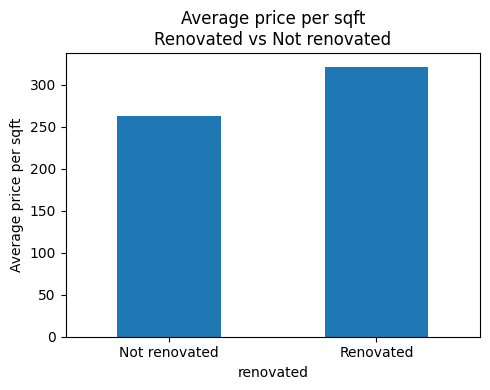

In [27]:
# Average price per sqft by renovation status
avg_by_renovated = (
    df.groupby("renovated")["price_per_sqft"]
      .mean()
      .rename(index={False: "Not renovated", True: "Renovated"})
)

plt.figure(figsize=(5, 4))
avg_by_renovated.plot(kind="bar")

plt.ylabel("Average price per sqft")
plt.title("Average price per sqft\nRenovated vs Not renovated")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

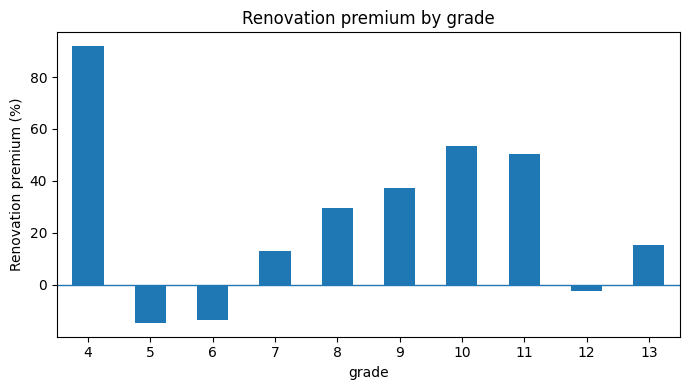

In [28]:
# Group by grade and renovation status
grade_stats = (
    df.groupby(["grade", "renovated"])["price_per_sqft"]
      .mean()
      .reset_index()
)

# Pivot to get renovated vs not in columns
grade_pivot = grade_stats.pivot(
    index="grade",
    columns="renovated",
    values="price_per_sqft"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

# Keep only grades that have both types
grade_pivot = grade_pivot.dropna(subset=["avg_not_renovated", "avg_renovated"])

# Calculate premium in percent
grade_pivot["premium_pct"] = (
    (grade_pivot["avg_renovated"] - grade_pivot["avg_not_renovated"])
    / grade_pivot["avg_not_renovated"]
) * 100

plt.figure(figsize=(7, 4))
grade_pivot["premium_pct"].plot(kind="bar")

plt.axhline(0, linewidth=1)
plt.ylabel("Renovation premium (%)")
plt.title("Renovation premium by grade")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

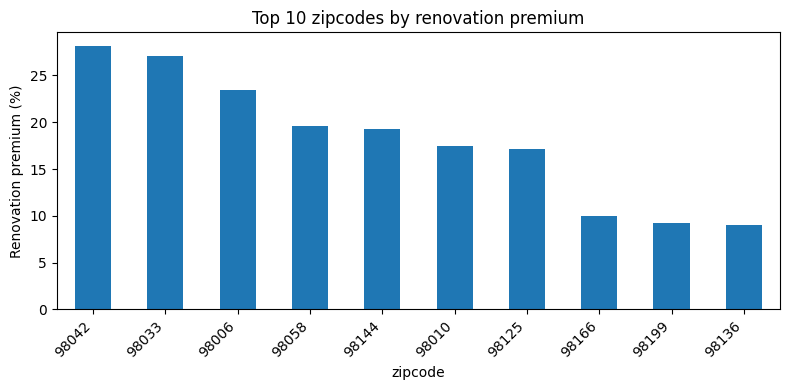

renovated,avg_not_renovated,avg_renovated,premium_pct
zipcode,,,
98042,163.500,209.500,28.200
98033,339.400,431.300,27.100
98006,296.800,366.500,23.500
98058,177.400,212.200,19.600
98144,308.300,367.700,19.300
98010,206.500,242.500,17.500
98125,280.400,328.600,17.200
98166,224.300,246.700,10.000
98199,374.100,408.800,9.300


In [29]:
# Group by zipcode and renovation status
zip_stats = (
    df.groupby(["zipcode", "renovated"])["price_per_sqft"]
      .agg(["mean", "count"])
      .reset_index()
)

# Pivot
zip_pivot = zip_stats.pivot(
    index="zipcode",
    columns="renovated",
    values="mean"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

# Drop zipcodes without both
zip_pivot = zip_pivot.dropna(subset=["avg_not_renovated", "avg_renovated"])

# Add counts to filter for stable results
zip_counts = (
    zip_stats.pivot(
        index="zipcode",
        columns="renovated",
        values="count"
    ).rename(columns={False: "count_not_renovated", True: "count_renovated"})
)

zip_pivot = zip_pivot.join(zip_counts)

# Filter: at least 20 non-renovated and 10 renovated sales
zip_pivot_filtered = zip_pivot[
    (zip_pivot["count_not_renovated"] >= 20) &
    (zip_pivot["count_renovated"] >= 10)
]

# Calculate premium
zip_pivot_filtered["premium_pct"] = (
    (zip_pivot_filtered["avg_renovated"] - zip_pivot_filtered["avg_not_renovated"])
    / zip_pivot_filtered["avg_not_renovated"]
) * 100

# Take top 10 by premium
top_zip = zip_pivot_filtered.sort_values("premium_pct", ascending=False).head(10)

plt.figure(figsize=(8, 4))
top_zip["premium_pct"].plot(kind="bar")

plt.ylabel("Renovation premium (%)")
plt.title("Top 10 zipcodes by renovation premium")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top_zip[["avg_not_renovated", "avg_renovated", "premium_pct"]].round(1)

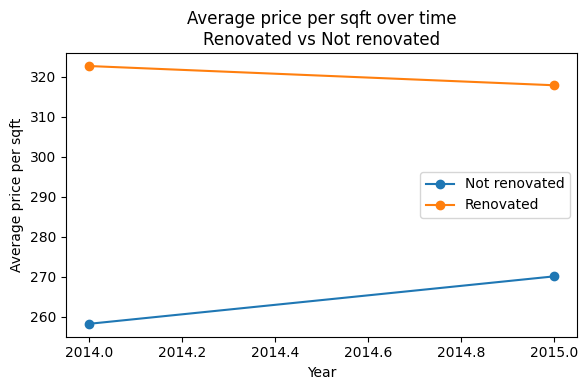

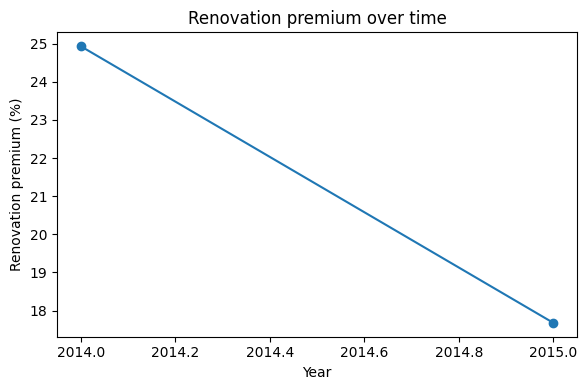

renovated,avg_not_renovated,avg_renovated,premium_pct
sale_year,,,
2014,258.300,322.700,24.900
2015,270.100,317.900,17.700


In [30]:
# Ensure date is datetime and extract year
df["date"] = pd.to_datetime(df["date"])
df["sale_year"] = df["date"].dt.year

year_stats = (
    df.groupby(["sale_year", "renovated"])["price_per_sqft"]
      .mean()
      .reset_index()
)

year_pivot = year_stats.pivot(
    index="sale_year",
    columns="renovated",
    values="price_per_sqft"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

year_pivot = year_pivot.dropna(subset=["avg_not_renovated", "avg_renovated"])

# Option A: plot both lines (renovated vs not)
plt.figure(figsize=(6, 4))
plt.plot(year_pivot.index, year_pivot["avg_not_renovated"], marker="o", label="Not renovated")
plt.plot(year_pivot.index, year_pivot["avg_renovated"], marker="o", label="Renovated")

plt.xlabel("Year")
plt.ylabel("Average price per sqft")
plt.title("Average price per sqft over time\nRenovated vs Not renovated")
plt.legend()
plt.tight_layout()
plt.show()

# Option B: plot premium percentage by year
year_pivot["premium_pct"] = (
    (year_pivot["avg_renovated"] - year_pivot["avg_not_renovated"])
    / year_pivot["avg_not_renovated"]
) * 100

plt.figure(figsize=(6, 4))
plt.plot(year_pivot.index, year_pivot["premium_pct"], marker="o")

plt.xlabel("Year")
plt.ylabel("Renovation premium (%)")
plt.title("Renovation premium over time")
plt.tight_layout()
plt.show()

year_pivot.round(1)

In [31]:
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month

monthly_stats = (
    df.groupby(["month", "renovated"])["price_per_sqft"]
      .mean()
      .reset_index()
)

monthly_pivot = monthly_stats.pivot(
    index="month",
    columns="renovated",
    values="price_per_sqft"
).rename(columns={False: "avg_not_renovated", True: "avg_renovated"})

monthly_pivot["premium_pct"] = (
    (monthly_pivot["avg_renovated"] - monthly_pivot["avg_not_renovated"])
    / monthly_pivot["avg_not_renovated"]
) * 100

monthly_pivot.round(1)

renovated,avg_not_renovated,avg_renovated,premium_pct
month,,,
1,255.300,305.700,19.800
2,259.100,287.800,11.100
3,272.300,314.100,15.300
4,277.400,328.600,18.400
5,265.900,339.800,27.800
6,262.400,335.700,27.900
7,257.600,315.600,22.500
8,257.100,342.000,33.000
9,257.400,303.400,17.900


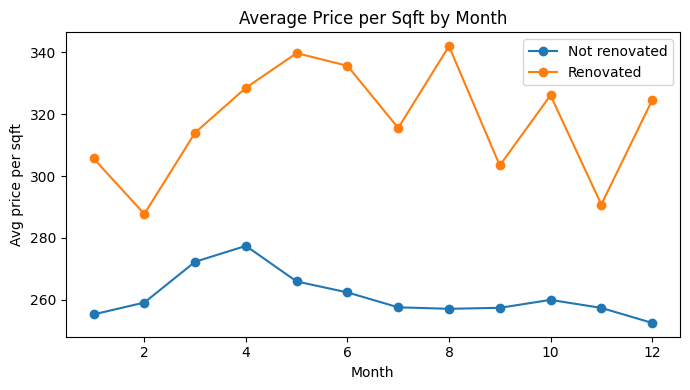

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(monthly_pivot.index, monthly_pivot["avg_not_renovated"], marker="o", label="Not renovated")
plt.plot(monthly_pivot.index, monthly_pivot["avg_renovated"], marker="o", label="Renovated")

plt.title("Average Price per Sqft by Month")
plt.xlabel("Month")
plt.ylabel("Avg price per sqft")
plt.legend()
plt.tight_layout()
plt.show()

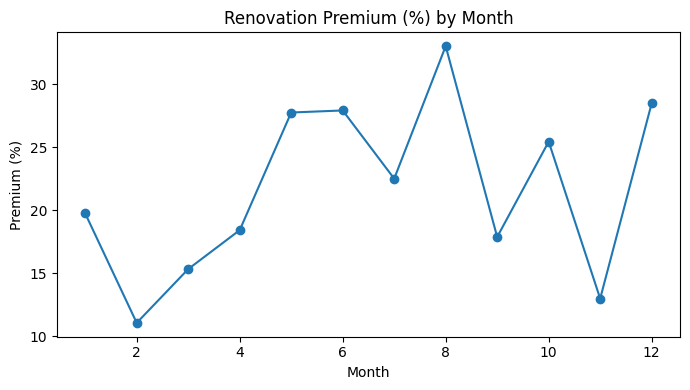

In [33]:
plt.figure(figsize=(7,4))
plt.plot(monthly_pivot.index, monthly_pivot["premium_pct"], marker="o")
plt.title("Renovation Premium (%) by Month")
plt.xlabel("Month")
plt.ylabel("Premium (%)")
plt.tight_layout()
plt.show()